# Forontiers Pipe

## Importing code

In [17]:
%load_ext autoreload
%autoreload 2

import os
from os import listdir
from os.path import isfile, join, isdir
import shutil
import pygraphviz
import networkx
import plotly
import rpy2
from tkinter import filedialog
from tkinter import *
import itertools
import threading
import subprocess
from functools import partial
import Processing.include_exclude_alignment as in_ex_align
import Processing.genome_3nt as genome_3nt
from Processing.analyze_editing_percent import filter_pileup_by_categories,analyse_multiple_editing_percent_files
from Processing.pileup_sorting import pileup_sort
from parallel_commands import parallel_commands, Command
from Processing.union_set_pileup import union_pileups
from Filtering.filter_pileup_by_multiple_existing_snps import snp_algebra, snp_detect
from Filtering.filter_pileup_by_consensus_site import filter_by_consensus
from Experiments.forontiers_jupyter.site_loss_by_group_plot import site_loss_by_group_plot
from Experiments.forontiers_jupyter.editing_type_count_by_group_plot import editing_type_count_by_group
from pipe_utils import *
from PIL import Image #has to be imported after pipe_utils/tkinter to avoid Image being overwritten


#import Processing.genome_to_transcriptome # Todo - check what is the real name


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Aligning the data

### Building the allignment graph spec

Now we are building the allignment graph. this graph allows us to run number of alignments one after the other , which each alignment is on the fastq files which containes the lines the previous alignment didn't align.

Beside the alignment that is being done in each step, we can do an additional action before or\and after the alignment. 

Below, we are defining a spec_dict that will contain the structure of the alignments and before and\or after actions.


#### Defining the alignment nodes

We define the different types of alignments in a python dictionary where:
* the key is the name we choose for this alignment
* the value is a 3-tuple of the form (alignment_flags,preprocessing_func,post_processing_func)

In [18]:
#alignment types these are flags that will go to the aligner
norep_align = " -m 2 -n 3"
repetative_align = " -m 100 -n 3 "

In [19]:
# building dict

#no special processing
spec_dict = dict()
spec_dict["norep"]=(norep_align,None,None)
spec_dict["rep"]=(repetative_align,None,None)

#adding non rep and rep 3nt genome

for base_pairs_name,pre,post in genome_3nt_all_combination_spec():
    spec_dict["norep_hyper_"+base_pairs_name]=(norep_align,pre,post)

for base_pairs_name,pre,post in genome_3nt_all_combination_spec():
    spec_dict["rep_hyper_"+base_pairs_name]=(repetative_align,pre,post)

#adding rep and norep transcriptome for each 3nt combination
#TODO - if you want to remove the transcriptom , delete it here
for base_pairs_name in all_genome_pair_combinations():
    spec_dict["norep_transcriptome_"+"_".join(base_pairs_name)]=(norep_align,transcriptom_func,None)
    

for base_pairs_name in all_genome_pair_combinations():
    spec_dict["rep_transcriptome_"+"_".join(base_pairs_name)]=(repetative_align,transcriptom_func,None)
    
#print(spec_dict)

#### Defining the graph dependecies

To define our graph dependencies, we generate a dictionary whos keys are all the names of `spec_dict` and the values of each key, `k`, is a list with the names of "fathers" of `k`.

In [20]:
# generate empty dict
graph_dict={name:[] for name in spec_dict.keys()}

for key,fathers in graph_dict.items():
    # non rep is starting node
    if key == "norep":
        continue
    
    # rep is son of norep
    if key == "rep":
        fathers.append("norep")
        continue
    
    # if we reached here, the name has a base_pair
    key_split=key.split('_')
    base_pair_name='_'.join(key_split[-2:])
    
    # hyper norep are all sons of rep
    if "norep_hyper_" in key:
        fathers.append("rep")
        continue
    
    # hyper rep is son of hyper norep with same bps
    if "rep_hyper_" in key:
        fathers.append("norep_hyper_"+base_pair_name)
        continue
    
    # hyper norep are all sons of rep
    if "norep_transcriptome_" in key:
        fathers.append("rep_hyper_"+base_pair_name)
        continue
    
    # hyper norep are all sons of rep
    if "rep_transcriptome_" in key:
        fathers.append("norep_transcriptome_"+base_pair_name)
        continue
    

#print(graph_dict)

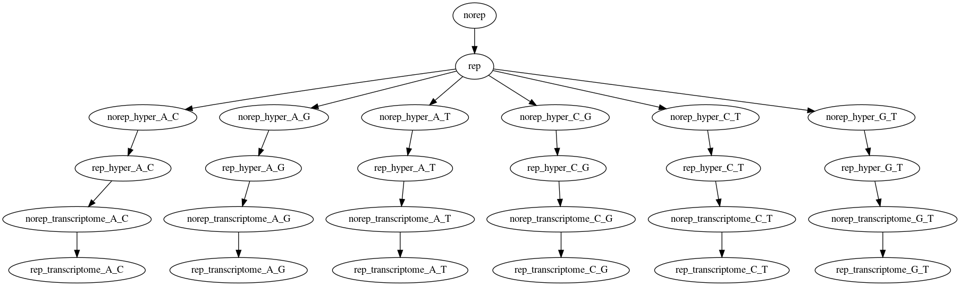

In [22]:
dg = networkx.DiGraph(graph_dict)
graphviz_dg = networkx.nx_agraph.to_agraph(dg.reverse())
graphviz_dg.layout(prog='dot')
graphviz_dg.draw('graph.png')
image = Image.open('graph.png')
image.thumbnail((960,960)) #keeps the ratio, but take the longer side in one of the bounderies consideration

display(image)

#### Defining the plot, groupings

Like in the case of 3nt genomes, we need to split a single conecpt into multiple alignment nodes even though we would like to aggregate all said nodes for visualization and statistics. Conversly, sometimes there are too many nodes for a metadata plot of all of them to be managable and we would like to cluster the nodes for visualization purposes.

Here we group our nodes into distinct groups, using a dictionary, they key will be the name of the group and the value will be a set of all node names belonging to our group.

In [23]:
group_dict ={
    "norep":{"norep"},
    "rep":{"rep"},
    "norep_hyper":{"norep_hyper_"+"".join(name) for name in all_genome_pair_combinations()},
    "rep_hyper":{"rep_hyper_"+"".join(name) for name in all_genome_pair_combinations()},
    "norep_transcriptome":{"norep_transcriptome_"+"".join(name) for name in all_genome_pair_combinations()},
    "rep_transcriptome":{"rep_transcriptome_"+"".join(name) for name in all_genome_pair_combinations()}
}

steps_reverse = ["rep_transcriptome","norep_transcriptome","rep_hyper","norep_hyper","rep","norep"]

#print(group_dict)

### Selecting your source files

choose analysis output folder

In [24]:
proj_folder ="/home/lammlab/Documents/frontiers_test/tt"

if proj_folder is None:
    proj_folder = folder_selector()
    print(proj_folder)

choose the exprimental rna seq fastqs for the analysis - mark a number of files by pressing "ctrl" in between files choosing

In [25]:
positive_fastqs = ['/home/lammlab/Documents/frontiers_test/files_for_test/test_test_mRNA.fastq']

if positive_fastqs is None:
    positive_fastqs = files_selector()
    print (positive_fastqs)

choose the reference fasta file for the analysis

In [26]:
reference_library = "/home/lammlab/Documents/frontiers_test/files_for_test/ws220-genes_expanded.fasta"

if reference_library is None:
    reference_library = file_selector()
    print(reference_library)
    

choose the control fastqs for the analysis (dna reads and ADAR mutant reads)- mark a number of files by pressing "ctrl" in between files choosing 

In [27]:
negative_fastqs = ['/home/lammlab/Documents/frontiers_test/files_for_test/test_test_negative.fastq']

if negative_fastqs is None:
    negative_fastqs = files_selector()
    print(negative_fastqs)

### Running alignment

Make sure that, your `spec,graph,group` dictionaries are configures properly. The next cell will run the inclusion exclusion alignment.

#### Creating the directories structure

In [28]:
original_output_folder_name = "original"
# creating the folders for the positive fastqs analysis, as subdirs of the proj_folder
fastq_projects_list = []
for fastq_file in positive_fastqs:
    new_proj=os.path.join(proj_folder,"results_"+os.path.basename(fastq_file).split(".")[0])
    if not os.path.exists(new_proj):
        os.mkdir(new_proj)
    fastq_projects_list.append(new_proj)

# creating the folders for the negative fastqs analysis, as subdirs of the proj_folder
neg_fastq_project_list = []
for fastq_file in negative_fastqs:
    new_proj=os.path.join(proj_folder,"results_"+os.path.basename(fastq_file).split(".")[0])
    if not os.path.exists(new_proj):
        os.mkdir(new_proj)
    neg_fastq_project_list.append(new_proj)

all_projects = [] + fastq_projects_list + neg_fastq_project_list

# creating the output folder of the pileup files from the alignment graph 
# and the subdirectories of the rest of the analysis
for project in all_projects:
    if project in fastq_projects_list:
        # creating the results folder of the editing type plot for the positive fastqs
        if not os.path.exists(new_proj):
            os.mkdir(os.path.join(project,"editing_type_plot"))
            os.mkdir(os.path.join(project,"site_loss_plot"))
    for group in group_dict.keys():
        dir1=os.path.join(project,group)
        if not os.path.exists(new_proj):
            os.mkdir(dir1) 
        # creating the pileup results folders for every group (the folder before filterring), 
        # for negative and positive fastqs
        if not os.path.exists(new_proj):
            os.mkdir(os.path.join(dir1, original_output_folder_name))
            os.mkdir(os.path.join(dir1, "sorted_pileups"))
        if project in fastq_projects_list:
            # creating the results filterring folders for the positive fastqs steps.
            if not os.path.exists(os.path.join(dir1,"no_change_filterout")):
                os.mkdir(os.path.join(dir1,"no_change_filterout"))
                os.mkdir(os.path.join(dir1,"reads_threshold_filterout"))
                os.mkdir(os.path.join(dir1,"snp_removed"))
                os.mkdir(os.path.join(dir1,"editing_sites_filterout"))
                os.mkdir(os.path.join(dir1,"consensus_filterout"))
                os.mkdir(os.path.join(dir1,"editing_percent_analysis"))


##### directories structure overview
this is how the directories structure looks like:

In [29]:
print_structure(proj_folder)

tt/
    results_test_test_mRNA/
        test_test_mRNA_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T_ntR.sam
        test_test_mRNA_norep_rep_nt_norep_hyper_C_G_ntR_nt_rep_hyper_C_G_ntR_norep_transcriptome_C_G.bowtie
        test_test_mRNA_norep_rep_nt_norep_hyper_C_G.bowtie
        test_test_mRNA_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T_ntR.fastq
        test_test_mRNA_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T_ntR_norep_transcriptome_G_T_rep_transcriptome_G_T.sam
        test_test_mRNA_norep_rep_nt_norep_hyper_A_T.bowtie
        test_test_mRNA_norep_rep.fastq
        test_test_mRNA_norep_rep_nt_norep_hyper_A_C_ntR_nt_rep_hyper_A_C_ntR_norep_transcriptome_A_C.bowtie
        test_test_mRNA_norep_rep_nt_norep_hyper_A_C.bowtie
        test_test_mRNA_norep_rep_nt_norep_hyper_A_C_ntR_nt_rep_hyper_A_C_ntR_norep_transcriptome_A_C.sam
        test_test_mRNA_norep_rep_nt_norep_hyper_A_T_ntR_nt_rep_hyper_A_T_ntR_norep_transcriptome_A_T_rep_transcriptome_A_T.sam
        test_

#### aligning

In [ ]:
#calling the function that run's the analysis (alignments)
#TODO - maybe need to change from threads (threading lib) to multiprocessing - use the example of parallel_commands below
print(reference_library)
threads = []
for project, fastq_file in zip(fastq_projects_list,positive_fastqs):
    
    t = threading.Thread(target=in_ex_align.do_include_exclude_alignment, args=(fastq_file, reference_library, spec_dict, graph_dict, project))
    t.start()
    threads.append(t)

    #in_ex_align.do_include_exclude_alignment(fastq_file, reference_library, spec_dict,graph_dict, outdir=project)

for project, fastq_file in zip(neg_fastq_project_list,negative_fastqs):
    t = threading.Thread(target=in_ex_align.do_include_exclude_alignment, args=(fastq_file, reference_library, spec_dict, graph_dict, project))
    t.start()
    threads.append(t)
    
for thread in threads:
    thread.join()
#for project, fastq_file in zip(neg_fastq_project_list, negative_fastqs):
#    in_ex_align.do_include_exclude_alignment(fastq_file, reference_library, spec_dict,graph_dict, project)


/home/lammlab/Documents/frontiers_test/files_for_test/ws220-genes_expanded.fasta
norep
fastqs = []
fathers = []
after pre
norep
fastqs = []
fathers = []
after pre
/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep.fastq
rep
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep.fastq']
fathers = ['norep']
after pre
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep.fastq
rep
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_t

Exception in thread Thread-57:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_C_ntR.fastq
rep_hyper_A_C
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_C_ntR.fastq']
fathers = ['norep_hyper_A_C']
after pre
/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_C.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_C.fastq
after action
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_G_T.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_G_T.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_C_ntR.fastq
rep_hyper_A_C
fastqs = ['/ho

/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR.fastq
norep_transcriptome_A_G
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR.fastq']
fathers = ['rep_hyper_A_G']
placeholder: transcriptome
after pre
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_G_T_ntR_nt_rep_hyper_G_T_ntR.fastq
norep_transcriptome_G_T
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_n

Exception in thread Thread-82:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''
rep_transcriptome_A_C
fastqs = [None]
stage rep_transcriptome_A_C couldn't be preformed - all the sequences were aligned in the steps before it


Exception in thread Thread-66:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''
rep_transcriptome_C_T
fastqs = [None]
stage rep_transcriptome_C_T couldn't be preformed - all the sequences were aligned in the steps before it


Exception in thread Thread-84:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq
rep_transcriptome_A_G
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/test_test_mRNA_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq']
fathers = ['norep_transcriptome_A_G']
placeholder: transcriptome
after pre
b''
rep_transcriptome_A_C
fastqs = [None]
stage rep_transcriptome_A_C couldn't be preformed - all the sequences were aligned in the steps before it


Exception in thread Thread-77:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''
rep_transcriptome_A_T
fastqs = [None]
stage rep_transcriptome_A_T couldn't be preformed - all the sequences were aligned in the steps before it


Exception in thread Thread-70:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''
rep_transcriptome_G_T
fastqs = [None]
stage rep_transcriptome_G_T couldn't be preformed - all the sequences were aligned in the steps before it


Exception in thread Thread-86:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''


Exception in thread Thread-85:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq
rep_transcriptome_A_G
fastqs = ['/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G.fastq']
fathers = ['norep_transcriptome_A_G']
placeholder: transcriptome
after pre
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_T_ntR_nt_rep_hyper_A_T_ntR_norep_transcriptome_A_T.sam
/hom

Exception in thread Thread-87:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

b''


Exception in thread Thread-80:
Traceback (most recent call last):
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 165, in do_pre_align_post
    pos, neg = action_func(pre_fastq, fasta_e, spec.flags, output_name, locking_context)
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 70, in bowtie_wrapper
    raise e
  File "/home/lammlab/Pipes/Processing/include_exclude_alignment.py", line 67, in bowtie_wrapper
    subprocess.check_output(command, shell=True)  # this will continue when the call is done
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line 376, in check_output
    **kwargs).stdout
  File "/home/lammlab/miniconda3/envs/py3/lib/python3.7/subprocess.py", line

/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G_rep_transcriptome_A_G.sam
/home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G_rep_transcriptome_A_G.fastq
after action
setting filename /home/lammlab/Documents/frontiers_test/tt/results_test_test_negative/test_test_negative_norep_rep_nt_norep_hyper_A_G_ntR_nt_rep_hyper_A_G_ntR_norep_transcriptome_A_G_rep_transcriptome_A_G.fastq


#### moving the files to folders

In [15]:
# moving the 

for project in all_projects:
#move each group to a unique group folder
    files = [f for f in listdir(project) if isfile(join(project, f))]
    print(files)
    #group_dict = dict()
    for step in group_dict.keys():
        for file in files:
            for step in steps_reverse:
                if "_"+step in file:
                    shutil.move(os.path.join(project,file),os.path.join(project,step))
                    break

# on each folder call to create a pileup from the sam files

['test_test_mRNA_norep_rep_nt_norep_hyper_C_G.bowtie', 'test_test_mRNA_norep_rep.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_A_C.bowtie', 'test_test_mRNA_norep_rep.sam', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_T_ntR_nt.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_A_C_ntR_nt.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_A_C.sam', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_G_ntR.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_A_C_sorted.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_T_ntR.sam', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_G.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_A_C_sorted.sam', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_T.bowtie', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_T_ntR.fastq', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_T.sam', 'test_test_mRNA_norep.bowtie', 'test_test_mRNA_norep_rep_nt_norep_hyper_C_G_ntR.sam', 'test_test_mRNA_norep_rep_nt.fastq', 'test_test_mRNA_norep_rep.bowtie', 'test_test_mRNA_norep_rep_nt_norep_hyper_G_T.bowtie

Error: Destination path '/home/lammlab/Documents/frontiers_test/tt/results_test_test_mRNA/norep_hyper/test_test_mRNA_norep_rep_nt_norep_hyper_C_G.bowtie' already exists

### Pileup creation

In [ ]:
#create bam

#TODO - maybe need to change from threads (threading lib) to multiprocessing - use the example of parallel_commands below
threads=[]
for project in all_projects:
    for group in group_dict.keys():
        dir1=os.path.join(project,group)
        files = [f for f in listdir(dir1) if (isfile(os.path.join(dir1, f)) and f.split(".")[-1] == "sam")]
        
        for file in files:
            sample_name=".".join(file.split(".")[:-1])
            command="samtools view -bS {file_name} > {out_name}.bam && samtools sort {out_name}.bam -o {out_name}.sorted_bam" \
                        .format(file_name=os.path.join(dir1,file), out_name=os.path.join(dir1,sample_name))
            '''print(command)
            res = subprocess.call(command,shell=True)
            if res:
                print("error")'''
            print(command)
            
            t = threading.Thread(target=call_process(command))
            t.start()
            threads.append(t)
    
for thread in threads:
    thread.join()


In [ ]:
#create pileup

#TODO - maybe need to change from threads (threading lib) to multiprocessing - use the example of parallel_commands below
for project in all_projects:
    for group in group_dict.keys():
        dir1=os.path.join(project,group)
        files = [f for f in listdir(dir1) if (isfile(os.path.join(dir1, f)) and f.split(".")[-1] == "sorted_bam")]
        output_folder = os.path.join(dir1, original_output_folder_name)
        #os.mkdir(output_folder)
        
        for file in files:
            sample_name=".".join(file.split(".")[:-1])
            command="samtools mpileup -f {fasta} {file_name} | tail -n +3 > {out_name}.pileup" \
                        .format(fasta=reference_library,file_name=os.path.join(dir1,file), out_name=os.path.join(output_folder,sample_name) )

            t = threading.Thread(target=call_process(command))
            t.start()
            threads.append(t)
    
for thread in threads:
    thread.join()
            

sorting the pileup files created

In [ ]:
commands = []
#TODO - move the raw data - bam,sam,sorted_bam to a new raw folder
# TODO - make sure in the sorting process that  the _sorted.pileup files doesnt get 
# to the folder otherwise the plot will not come out correctly 

for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir2=os.path.join(proj,group)
        indir=os.path.join(dir2,original_output_folder_name)
        outdir=os.path.join(dir2,"sorted_pileups")
        files = [f for f in listdir(indir) if ( isfile(os.path.join(indir, f)) and (f.split(".")[-1] == "pileup") and ("_sorted.pileup" not in f) ) ]
        
        for file in files:
            output=os.path.join(outdir,file)
            filename=os.path.join(indir,file)
            com=Command(pileup_sort,[filename,output])
            commands.append(com)
            
    
parallel_commands(commands)  

### Filter no change pileuplines
filter out the lines of pileup that shows no editing (the lins with only "." or "," in them)

In [ ]:

commands = []
for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir2=os.path.join(proj,group)
        dir1=os.path.join(dir2,"sorted_pileups")
        outdir=os.path.join(dir2,"no_change_filterout")
        files = [f for f in listdir(dir1) if (isfile(os.path.join(dir1, f)) and f.split(".")[-1] == "pileup") and "sorted.pileup" not in f]
        for file in files:
            pileup=os.path.join(dir1,file)
            output_pileup=os.path.join(outdir,file)
            args_array=[pileup,output_pileup,None,True,None,None]
            com=Command(filter_pileup_by_categories, args_array)
            commands.append(com)


parallel_commands(commands)                        
            

            

### Filter by reads threshold 

In [ ]:
import Processing.analyze_editing_percent as editing
commands = []
threshold=1 #todo - choose threashold - in 0-100 not 0.something
for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj,group)
        indir=os.path.join(dir1,"no_change_filterout")
        outdir=os.path.join(dir1,"reads_threshold_filterout")
        
        files = [f for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]
        for file in files:
            pileup=os.path.join(indir,file)
            output_pileup=os.path.join(outdir,file)
            com=Command(filter_pileup_by_categories,(pileup,output_pileup,threshold,None,None,None))
            commands.append(com)
            
parallel_commands(commands) 


### SNP removal of mutant and DNA 
todo - need to ask on what fasta (genes\chrome) to select the right file. and if need to do it twice

In [ ]:
#union_pileups

##### union the pileups for the negative files ####

# todo - maybe we dont need to union because of the snp removel script ?
commands=[]
for proj in neg_fastq_project_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj, group)
        indir=os.path.join(dir1, original_output_folder_name)
        output=os.path.join(indir,group+"_union.pileup")
        files = [os.path.join(indir,f) for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]

        com=Command(union_pileups,[files,output])
        commands.append(com)
        
parallel_commands(commands) 


In [ ]:
#SNP removal for the main fastq
negative_pileup_list = []
commands = []
for proj in neg_fastq_project_list:
    for group in group_dict.keys():
        dir2=os.path.join(proj,group)
        dir1 = os.path.join(dir2,original_output_folder_name)
        files = [ os.path.join(dir1,f) for f in listdir(dir1) if ( isfile(os.path.join(dir1, f)) and ("union" in f ) ) ]
        negative_pileup_list = negative_pileup_list + files

for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj,group)
        indir=os.path.join(dir1,"reads_threshold_filterout")
        outdir=os.path.join(dir1,"snp_removed")

        files = [f for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]
        
        for file in files:
            output=os.path.join(outdir,file)
            in_file=os.path.join(indir,file)
            com=Command(snp_algebra, [in_file,negative_pileup_list,snp_detect,output,True])
            commands.append(com)

parallel_commands(commands)


### Filter by editing sites (by editing percent and noise)

In [ ]:
commands = []
editing_thresold=10#todo - fill in read threshold
noise_threshold=90#todo - fill in read threshold
for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj,group)
        indir=os.path.join(dir1,"snp_removed")
        outdir=os.path.join(dir1,"editing_sites_filterout")
        #os.mkdir(outdir)
        files = [f for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]
        for file in files:
            pileup=os.path.join(indir,file)
            output_pileup=os.path.join(outdir,file)

            com=Command(filter_pileup_by_categories,[pileup,output_pileup,None,None,editing_thresold,noise_threshold])
            commands.append(com)
                
parallel_commands(commands)

### Consensus

In [ ]:
#TODO - CHECK  IF OUTPUT MAKE SENSE

is_sorted=True
k=0.3#todo- fill in the k
commands = []
for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj,group)
        indir=os.path.join(dir1,"editing_sites_filterout")
        outdir=os.path.join(dir1,"consensus_filterout")

        files = [os.path.join(indir,f) for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]
        com=Command(filter_by_consensus,[files,k,outdir,is_sorted])
        commands.append(com)
            
parallel_commands(commands)

### Site loss plot

In [ ]:
commands = []
list_order_of_folders=["consensus_filterout","editing_sites_filterout","snp_removed","reads_threshold_filterout","no_change_filterout"]
for proj in fastq_projects_list:
    outdir = os.path.join(proj,"site_loss_plot")
    output_file_name=os.path.join(outdir,"site_loss_plot.png")
    folders = [os.path.join(proj,f) for f in listdir(proj) if isdir(os.path.join(proj, f)) and "site_loss_plot" not in f and "editing_type_plot" not in f]

    com=Command(site_loss_by_group_plot,[folders,output_file_name,original_output_folder_name,list_order_of_folders])
    commands.append(com)
            
parallel_commands(commands)

### Editing type count plot

#### Editing percent analysis

In [ ]:
commands = []
min_editing=0.0#todo- fill up
max_noise=1.0#todo- fill up
min_reads=1#todo- fill up
for proj in fastq_projects_list:
    for group in group_dict.keys():
        dir1=os.path.join(proj,group)
        indir=os.path.join(dir1,"consensus_filterout") #input : the pileups after the intire thing of filtering
        outdir=os.path.join(dir1,"editing_percent_analysis")


        files = [os.path.join(indir, f) for f in listdir(indir) if (isfile(os.path.join(indir, f)) and f.split(".")[-1] == "pileup")]
                 
        #analyse_multiple_editing_percent_files(files,out_dir=outdir,add_headers=True, 
        #                                               min_editing=editing_percent_threshold,
        #                                               max_noise=noise_percent_threshold,
        #                                               min_reads=count_threshold, edit_tag="edited",csv_genes=True)
        vars_list=[files,outdir,None,True,False,min_editing,max_noise,min_reads,"edited",False]

        com=Command(analyse_multiple_editing_percent_files,vars_list)
        commands.append(com)
            
parallel_commands(commands)

#### plot

In [ ]:

commands = []
#input : the pileups after the intire thing - then do editing percent anaysis
for proj in fastq_projects_list:
    outdir=os.path.join(proj,"editing_type_plot")
    #os.mkdir(outdir)
    output_file_name=os.path.join(outdir,"editing_type_plot.png")
    list_of_dirs=[]
    for group in group_dict.keys():
        indir=os.path.join(os.path.join(proj,group),"editing_percent_analysis")
        list_of_dirs.append(indir)
    

    com=Command(editing_type_count_by_group,[list_of_dirs,output_file_name])
    commands.append(com)
            
parallel_commands(commands)